# 测算股东人数 N天减少M%的情况，并评估其后走势带来的收益累积

In [1]:
import pymysql
import pandas as pd
import pandas.io.sql as sql
import numpy as np
import tushare as ts
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Step 1 获取原始信息

#### Step 1.1 获取股票代码

In [2]:
# 获取股票清单
basic = ts.get_stock_basics() #tushare的数据直接是DataFrame

#### step 1.2 从mysql 获取股东人数信息

In [3]:
# 存到 DF [renshu] 中
try:
    conn = pymysql.connect(host='localhost', port=3306, user='root', passwd='111111', db='STOCK', charset='utf8')
    renshu = sql.read_sql('select * from Xq_gdhs_20170802', conn) #将数据库读入dataframe
    conn.close()
except pymysql.Error as e:
    print('Mysql Error %d: %s' %(e.args[0], e.args[1]))

In [4]:
#renshu

### 以上：原始信息获取完毕

### Step 2 进行 数据格式 整理

#### Step 2.1 去除人[renshu]中无关列，仅剩下 [code] [date] [renshu]

In [5]:
renshu = renshu.drop('index',axis=1) #丢弃mysql中原有的index列

In [6]:
# 丢弃重复数据
renshu = renshu.drop_duplicates() 

# 丢弃不知道怎么出来的将近1000行NA
renshu = renshu.dropna(how='all')

# 修改为更简单的列名
renshu.rename(columns={'name_code':'code','gdhs':'renshu'},inplace=True)
#renshu.info()

In [7]:
renshu.head()

,code,date,renshu
0,600000,20170331,173130
1,600000,20161231,160501
2,600000,20160930,162071
3,600000,20160630,173951
4,600000,20160331,184005


#### step 2.2 清理basic列，仅剩 [code] [name] [timeToMarket]即可

In [8]:
basic = basic.drop(['holders','industry','area','pe','outstanding','totals','totalAssets',\
                    'liquidAssets','fixedAssets','reserved','reservedPerShare','esp','bvps',
                    'pb','undp','perundp','rev','profit','gpr','npr'],axis=1) #丢弃mysql中原有的index列

In [9]:
#将作为索引的code还原为列名，为了后面跟股东数据merge
basic = basic.reset_index(drop=False)
#basic.info()

#### step 2.3 将 人数 和 上市时间信息 合并，得到所有股票 所有时间点 股东户数表格

In [10]:
renshuall = pd.merge(renshu, basic, on='code')

In [11]:
renshuall.head()

,code,date,renshu,name,timeToMarket
0,600000,20170331,173130,浦发银行,19991110
1,600000,20161231,160501,浦发银行,19991110
2,600000,20160930,162071,浦发银行,19991110
3,600000,20160630,173951,浦发银行,19991110
4,600000,20160331,184005,浦发银行,19991110


### Step 3 整理 数据格式

In [12]:
# 处理有几行 timeToMarket == 0 的特殊情况
renshuall = renshuall[renshuall.timeToMarket != 0] # 排除未上市新股[timeToMarket为0]

In [14]:
# 将date 和 timeToMarket 格式变成 datetime，方便后续计算
renshuall.date = pd.to_datetime(renshuall.date,format='%Y%m%d')
renshuall.timeToMarket = pd.to_datetime(renshuall.timeToMarket,format='%Y%m%d')

In [15]:
# 股东数 > 300人（未上市新股股东人数在 几十人）
renshuall = renshuall[renshuall['renshu']>300]

# 增加列 [daysToMarket]：计算股东数发布日期距离上市时间的天数（排除次新股）
renshuall['daysToMarket'] = renshuall.date - renshuall.timeToMarket
# 上市时间 > 90天，排除次新股
renshuall = renshuall[(renshuall.daysToMarket > timedelta(90))] 

/Users/samuel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [16]:
renshuall = renshuall.reset_index(drop=True)

In [17]:
# 增加列：相对上一期的变化率  &  较上一期的间隔时间
renshuall['pct'] = (renshuall['renshu'] - renshuall['renshu'].shift(-1)) / renshuall['renshu'].shift(-1)
renshuall['daygap'] = (renshuall['date'] - renshuall['date'].shift(-1))

# 将不同股票的 pct 和daygap设置为0 
n = 0
while n < len(renshuall)-1:
    #print(n)
    #print(renshuall.loc[n,'code'],renshuall.loc[n+1,'code'],renshuall.loc[n,'pct'])
    if renshuall.loc[n,'code'] != renshuall.loc[n+1,'code']:
        renshuall.at[n,'daygap'] = 0
        renshuall.at[n,'pct'] = 0
        n += 1
    else:
        n += 1
        continue

### Step 4 数据筛选： N天内缩减 M%

In [65]:
data = renshuall.copy()
condition3020 = 0
condition2013 = 1

#data

In [66]:
if condition3020: ## 32天内缩减 20%
    data = data[(data.pct < -0.2) & (data.daygap < timedelta(32)) & (data.daygap > timedelta(0))]
elif condition2013: ## 20天内缩减 15% 
    data = data[(data.pct < -0.15) & (data.daygap < timedelta(20)) & (data.daygap > timedelta(0))]

### Step 5 获取筛选出来的股票 前 后 N个日历日的股价信息

In [67]:
code = data.code
date = []
startlast = 20
endlast = 60
#初始化两个空DataFrame
priceafter = pd.DataFrame()
pricebefore = pd.DataFrame()
#code

In [68]:
data.drop_duplicates(subset='name',keep='first',inplace=True)

In [69]:
# 设置一个 信息公布前N日的开关，暂时不用
tag_bf = 0

In [70]:
def formatDate(Date, formatType='YYYYMMDD'):
    #print('Inner Date == ',Date)
    formatType = formatType.replace('YYYY', Date[0:4])
    formatType = formatType.replace('MM', Date[5:7])
    formatType = formatType.replace('DD', Date[8:10])
    return formatType

In [71]:
data = data.set_index('code')

In [72]:
# 获取 data 选出的股票后30天的走势
for c in code:
    #print('AA ',c,'date=', date,'; Start =',start,'; end =  ', end)
    date = data.loc[c]['date']
    date2 = str(date)[0:10]
    
    enddate = date + timedelta(endlast)
    enddate = str(enddate)[0:10]
    #end = formatDate(str(end),'YYYYMMDD')
    
    
    startdate = date - timedelta(startlast)
    startdate = str(startdate)[0:10]
    #start = formatDate(str(start),'YYYYMMDD')
    #print('BB ',c,'date2=', date2,'; startdate =',startdate,'; end =',enddate)
    date = formatDate(str(date),'YYYYMMDD')
    
    #先获取数据日之后的行情，放入priceafter 
    p = ts.get_k_data(c, start=date2, end=enddate, autype='qfq')
    if tag_bf:
        q = ts.get_k_data(c, start=startdate, end=date2, autype='qfq')
    
    preturns = p['close'].pct_change()
    p['pct_change'] = (1 + preturns).cumprod() #逐行累积
    p = p.reset_index()
    
    if tag_bf:    
        qreturns = q['close'].pct_change()
        q['pct_change'] = (1 + qreturns).cumprod() #逐行累积
        q = q.reset_index()
    
    priceafter = priceafter.append(p)
    if tag_bf:
        pricebefore = pricebefore.append(q)

In [73]:
priceafter_copy = priceafter.copy()
if tag_bf:
    pricebefore_copy = pricebefore.copy()
priceafter_copy.head()

,index,date,open,close,high,low,volume,code,pct_change
0,55,2015-03-31,5.27,5.37,5.44,5.27,306791.0,600069,NaN
1,56,2015-04-01,5.37,5.42,5.45,5.35,241815.0,600069,1.009311
2,57,2015-04-02,5.43,5.57,5.69,5.43,314956.0,600069,1.037244
3,58,2015-04-03,5.55,5.63,5.71,5.55,251341.0,600069,1.048417
4,59,2015-04-07,5.63,5.64,5.65,5.54,373426.0,600069,1.050279


In [74]:
priceafter_copy = priceafter_copy.drop(['index'],axis=1)
#priceafter_copy = priceafter_copy.set_index('code')
if tag_bf:
    pricebefore_copy = pricebefore_copy.drop(['index'],axis=1)
    pricebefore_copy = pricebefore_copy.set_index('code')
#pricebefore_copy

In [75]:
#去除重复行
if tag_bf:
    pricebefore_copy.drop_duplicates(inplace=True)
priceafter_copy.drop_duplicates(inplace=True)

In [76]:
if tag_bf:
    pricebefore_copy.groupby(['code']).pct_change.plot(figsize=(16,9),grid=True)

In [77]:
if tag_bf:
    pricebefore_copy['pct_change2'] = pricebefore_copy['pct_change']
    pricebefore_copy[pricebefore_copy.pct_change2 > 1.3]

In [100]:
%config InlineBackend.figure_format = 'retina'

code
000513    Axes(0.125,0.125;0.775x0.755)
000625    Axes(0.125,0.125;0.775x0.755)
000651    Axes(0.125,0.125;0.775x0.755)
000797    Axes(0.125,0.125;0.775x0.755)
000821    Axes(0.125,0.125;0.775x0.755)
000852    Axes(0.125,0.125;0.775x0.755)
002035    Axes(0.125,0.125;0.775x0.755)
002048    Axes(0.125,0.125;0.775x0.755)
002081    Axes(0.125,0.125;0.775x0.755)
002098    Axes(0.125,0.125;0.775x0.755)
002110    Axes(0.125,0.125;0.775x0.755)
002170    Axes(0.125,0.125;0.775x0.755)
002189    Axes(0.125,0.125;0.775x0.755)
002216    Axes(0.125,0.125;0.775x0.755)
002345    Axes(0.125,0.125;0.775x0.755)
002359    Axes(0.125,0.125;0.775x0.755)
002366    Axes(0.125,0.125;0.775x0.755)
002430    Axes(0.125,0.125;0.775x0.755)
002460    Axes(0.125,0.125;0.775x0.755)
002466    Axes(0.125,0.125;0.775x0.755)
002589    Axes(0.125,0.125;0.775x0.755)
002606    Axes(0.125,0.125;0.775x0.755)
002629    Axes(0.125,0.125;0.775x0.755)
002676    Axes(0.125,0.125;0.775x0.755)
002753    Axes(0.125,0.125;0.775x0.

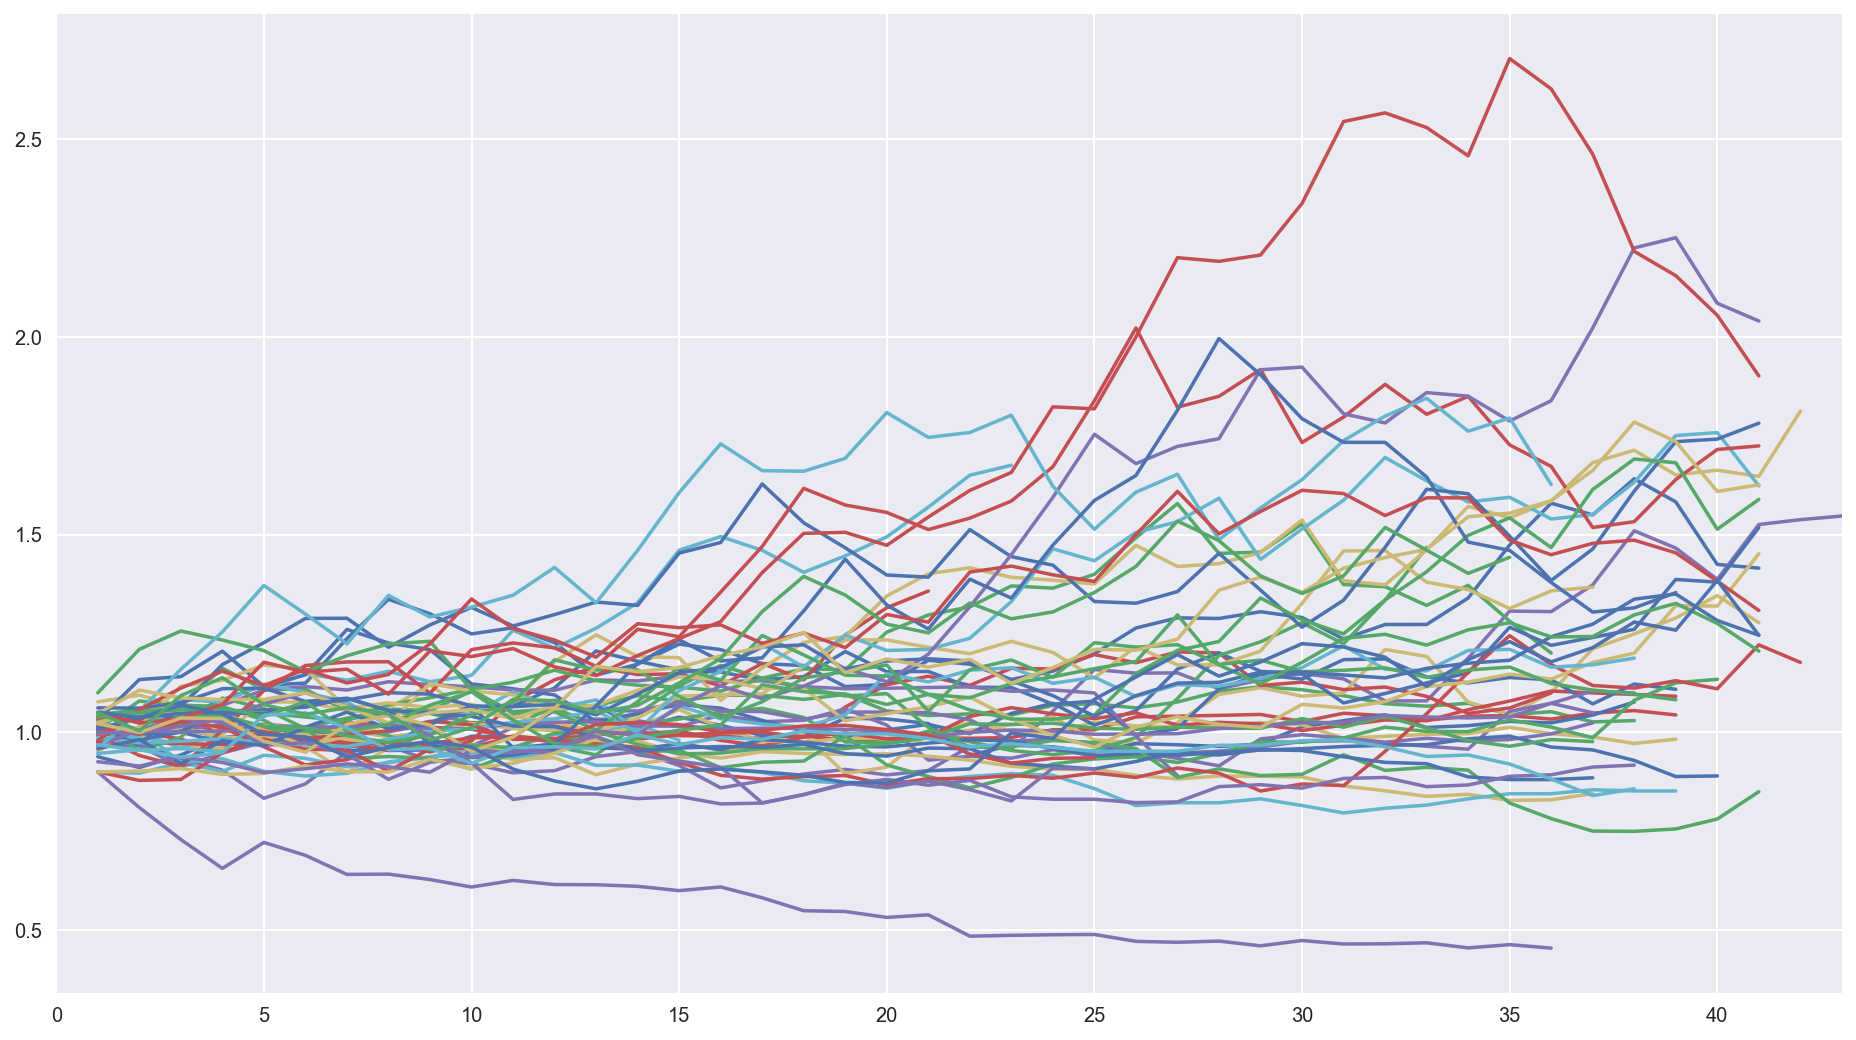

In [101]:
priceafter_copy.groupby(['code']).pct_change.plot(figsize=(16,9),grid=True)

In [102]:
demo_data = priceafter_copy.groupby(['code']).pct_change.describe()
demo_data

,count,mean,std,min,25%,50%,75%,max
code,,,,,,,,
000513,41.0,1.255108,0.149509,1.036848,1.154933,1.236345,1.300012,1.641379
000625,38.0,1.055259,0.034674,0.976421,1.031567,1.058175,1.078559,1.115469
000651,39.0,1.012398,0.024961,0.977795,0.988728,1.006780,1.040258,1.055259
000797,43.0,1.080462,0.213727,0.833607,0.911440,0.967348,1.154882,1.547256
000821,41.0,1.043736,0.116263,0.893155,0.960800,1.019842,1.096037,1.346185
000852,15.0,0.946144,0.039050,0.897002,0.918140,0.937740,0.971176,1.020753
002035,38.0,0.997023,0.039438,0.911293,0.968169,0.991712,1.026958,1.076867
002048,36.0,1.227032,0.163331,1.020020,1.066892,1.165827,1.368966,1.578694
002081,36.0,1.059952,0.078264,0.948414,0.994551,1.036559,1.119540,1.203621


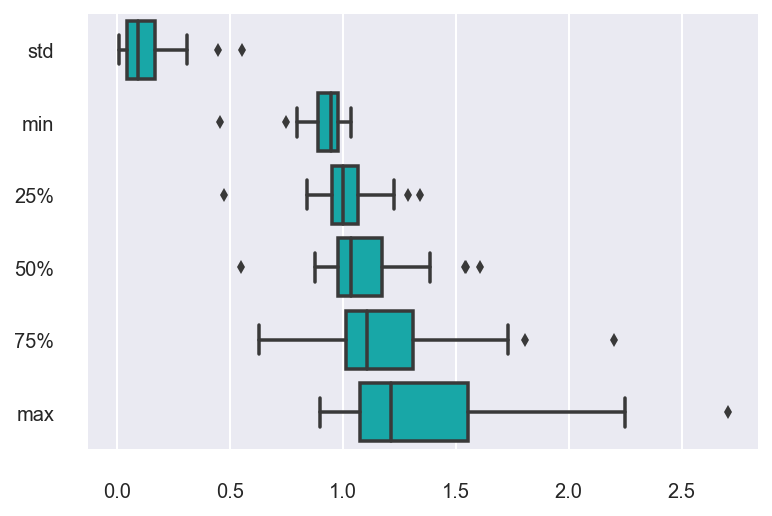

In [104]:
import seaborn as sns
demo_data = demo_data.loc[:,demo_data.columns[1:]]
#sns.boxplot(data=demo_data,orient="h",color="c")
sns.boxplot(data=demo_data,orient="h",color="c")
sns.despine(trim=True,offset=10)

In [106]:
priceafter3 = priceafter_copy.reset_index()

In [107]:
priceafter3['day_of_code'] = 0
n = 0
m = 1
while n < len(priceafter3)-1:
    #print(n,priceafter3.loc[n,'code'],priceafter3.loc[n+1,'code'])
    if priceafter3.loc[n,'code'] ==  priceafter3.loc[n+1,'code']:
        priceafter3.at[n,'day_of_code'] = m
        n += 1
        m += 1
    else:
        priceafter3.at[n,'day_of_code'] = m
        m = 1
        n += 1
        continue
priceafter3

,index,date,open,close,high,low,volume,code,pct_change,day_of_code
0,0,2015-03-31,5.27,5.37,5.44,5.27,306791.0,600069,NaN,1
1,1,2015-04-01,5.37,5.42,5.45,5.35,241815.0,600069,1.009311,2
2,2,2015-04-02,5.43,5.57,5.69,5.43,314956.0,600069,1.037244,3
3,3,2015-04-03,5.55,5.63,5.71,5.55,251341.0,600069,1.048417,4
4,4,2015-04-07,5.63,5.64,5.65,5.54,373426.0,600069,1.050279,5
5,5,2015-04-08,5.66,5.62,5.75,5.51,370329.0,600069,1.046555,6
6,6,2015-04-09,5.75,5.76,5.85,5.53,431803.0,600069,1.072626,7
7,7,2015-04-10,5.75,5.81,5.84,5.71,308748.0,600069,1.081937,8
8,8,2015-04-13,6.06,5.91,6.06,5.90,383471.0,600069,1.100559,9
9,9,2015-04-14,5.92,5.89,5.97,5.84,293094.0,600069,1.096834,10


In [108]:
priceafter3.day_of_code.sort_values()

2019     0
1006     1
993      1
967      1
925      1
885      1
845      1
808      1
794      1
752      1
726      1
684      1
1011     1
646      1
565      1
526      1
484      1
446      1
404      1
362      1
324      1
288      1
246      1
207      1
165      1
607      1
126      1
1053     1
1132     1
1983     1
        ..
1051    41
724     41
1980    41
1172    41
1761    41
286     41
205     41
1052    42
41      42
525     42
403     42
606     42
206     42
1939    42
83      42
125     42
725     42
1853    42
1217    42
445     42
1173    42
1490    42
287     42
1981    42
966     42
793     42
1174    43
1982    43
1854    43
1175    44
Name: day_of_code, Length: 2020, dtype: int64

In [109]:
# 看 10天之后的涨跌幅结果
d03 = priceafter3[priceafter3.day_of_code == 3].reset_index()
d05 = priceafter3[priceafter3.day_of_code == 5].reset_index()
d10 = priceafter3[priceafter3.day_of_code == 10].reset_index()
d15 = priceafter3[priceafter3.day_of_code == 15].reset_index()
d18 = priceafter3[priceafter3.day_of_code == 18].reset_index()
d20 = priceafter3[priceafter3.day_of_code == 20].reset_index()
d22 = priceafter3[priceafter3.day_of_code == 22].reset_index()
d25 = priceafter3[priceafter3.day_of_code == 25].reset_index()
d30 = priceafter3[priceafter3.day_of_code == 30].reset_index()
#d10

In [110]:
endprice = pd.DataFrame({"d03": d03["pct_change"],
                         "d05": d05["pct_change"],
                         "d10": d10["pct_change"],
                         "d15": d15["pct_change"],
                         "d18": d18["pct_change"],
                         "d20": d20["pct_change"],
                         "d22": d15["pct_change"],
                         "d25": d25["pct_change"],
                         "d30": d30["pct_change"]
                        })
#endprice

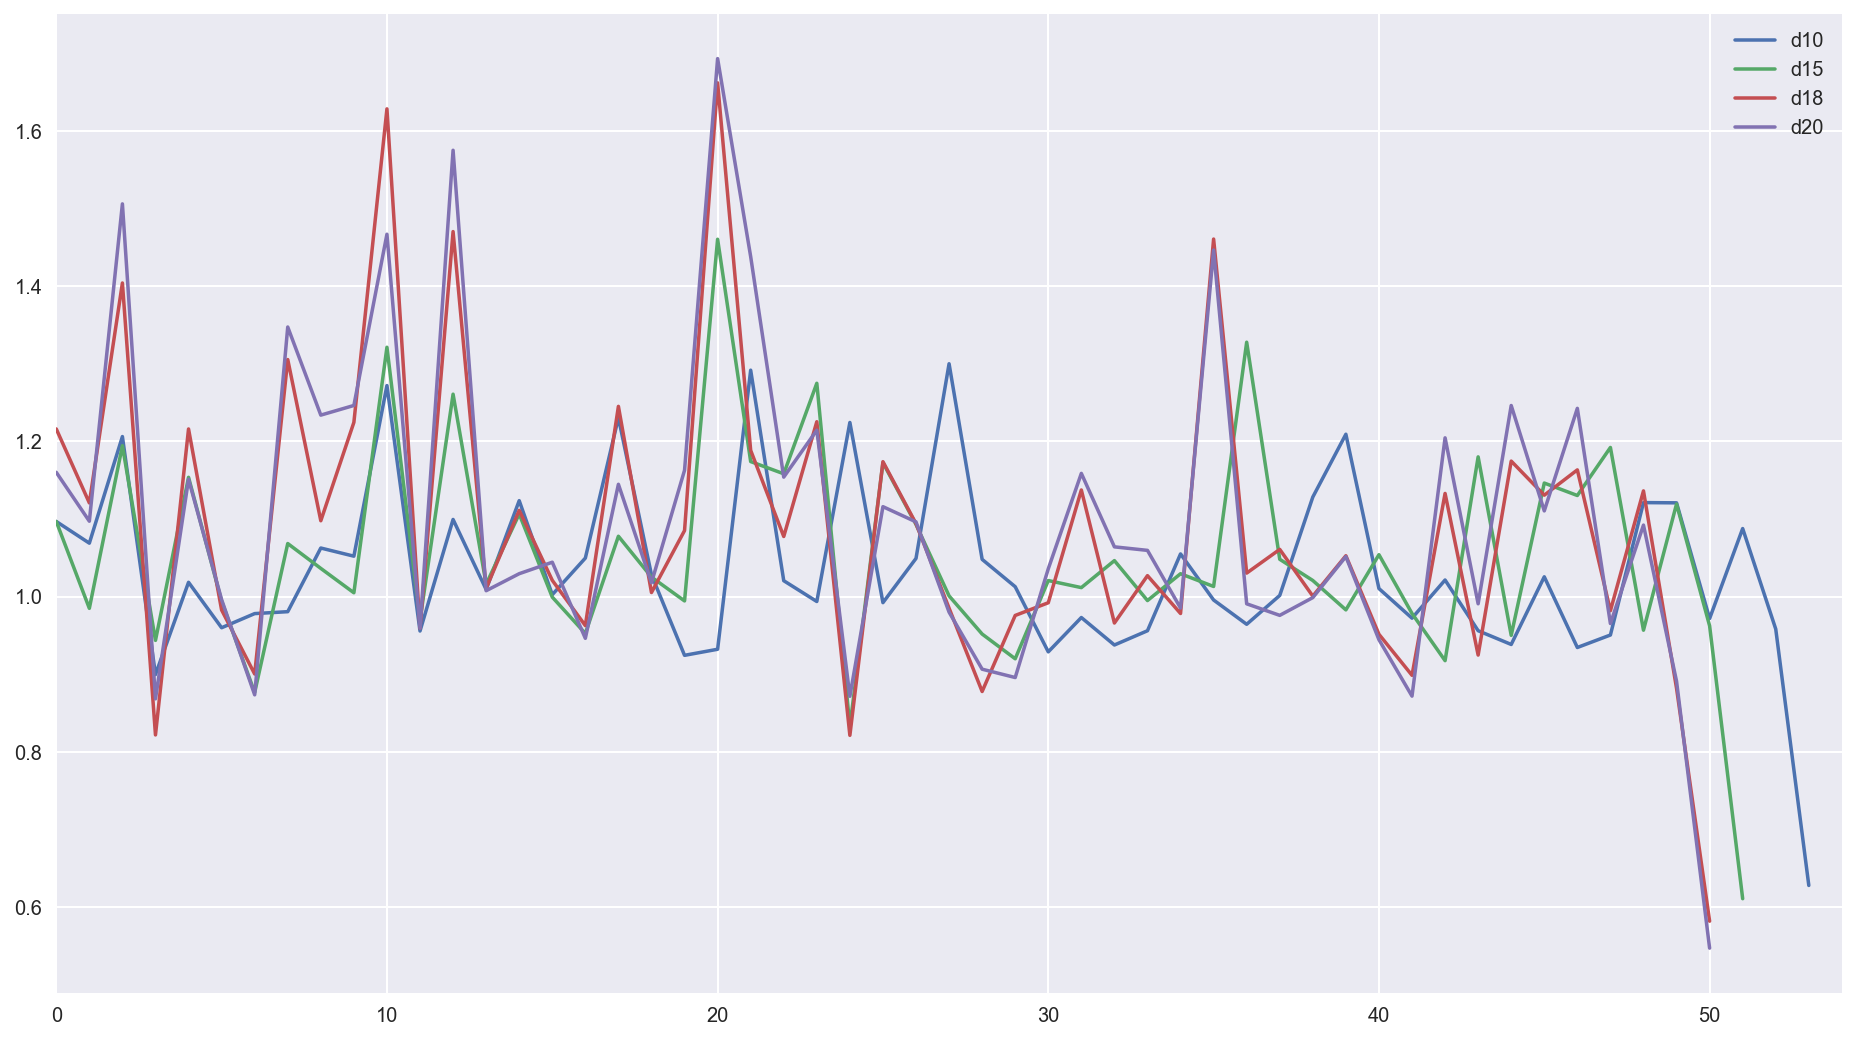

In [111]:
pd.DataFrame(endprice[['d10','d15','d18','d20']]).plot(figsize=(16,9),grid=True)

In [112]:
endprice.describe()

,d03,d05,d10,d15,d18,d20,d22,d25,d30
count,55.000000,55.000000,54.000000,52.000000,51.000000,51.000000,52.000000,49.000000,46.000000
mean,1.002883,1.026736,1.032066,1.054066,1.088922,1.099506,1.054066,1.115040,1.193493
std,0.063884,0.095540,0.113917,0.137036,0.196862,0.206861,0.137036,0.247859,0.327932
min,0.810072,0.656295,0.628058,0.610971,0.582014,0.547302,0.610971,0.488489,0.460432
25%,0.973948,0.977137,0.961087,0.981827,0.977070,0.978000,0.981827,0.961883,0.978269
50%,1.000000,1.025219,1.011620,1.023019,1.060893,1.059616,1.023019,1.046867,1.127802
75%,1.039404,1.069635,1.083013,1.134305,1.174241,1.183675,1.134305,1.163876,1.354927
max,1.210135,1.254132,1.300012,1.460359,1.661796,1.693054,1.460359,1.823232,2.207071


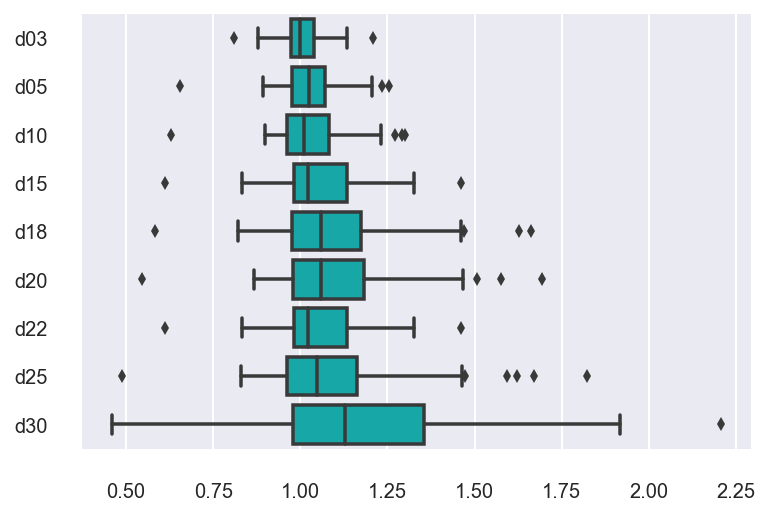

In [113]:
sns.boxplot(data=endprice,orient="h",color="c")
sns.despine(trim=True,offset=10)

# 以下部分未完成
#### 尝试设置止损线，看是否会提高盈利率

In [1118]:
priceafter4 = priceafter3.copy()
priceafter4.head()

,code,date,open,close,high,low,volume,pct_change,day_of_code
0,600069,2015-03-31,5.27,5.37,5.44,5.27,306791.0,NaN,1
1,600069,2015-04-01,5.37,5.42,5.45,5.35,241815.0,1.009311,2
2,600069,2015-04-02,5.43,5.57,5.69,5.43,314956.0,1.037244,3
3,600069,2015-04-03,5.55,5.63,5.71,5.55,251341.0,1.048417,4
4,600069,2015-04-07,5.63,5.64,5.65,5.54,373426.0,1.050279,5


In [1119]:
priceafter4 = priceafter4.dropna(how='any')
priceafter4['pct_change2'] = priceafter4['pct_change']
priceafter4

,code,date,open,close,high,low,volume,pct_change,day_of_code,pct_change2
1,600069,2015-04-01,5.37,5.42,5.45,5.35,241815.0,1.009311,2,1.009311
2,600069,2015-04-02,5.43,5.57,5.69,5.43,314956.0,1.037244,3,1.037244
3,600069,2015-04-03,5.55,5.63,5.71,5.55,251341.0,1.048417,4,1.048417
4,600069,2015-04-07,5.63,5.64,5.65,5.54,373426.0,1.050279,5,1.050279
5,600069,2015-04-08,5.66,5.62,5.75,5.51,370329.0,1.046555,6,1.046555
6,600069,2015-04-09,5.75,5.76,5.85,5.53,431803.0,1.072626,7,1.072626
7,600069,2015-04-10,5.75,5.81,5.84,5.71,308748.0,1.081937,8,1.081937
8,600069,2015-04-13,6.06,5.91,6.06,5.90,383471.0,1.100559,9,1.100559
9,600069,2015-04-14,5.92,5.89,5.97,5.84,293094.0,1.096834,10,1.096834
10,600069,2015-04-15,5.89,5.73,6.05,5.72,281206.0,1.067039,11,1.067039


In [1116]:
priceafter4[priceafter4.pct_change2 > 0.95]

,code,date,open,close,high,low,volume,pct_change,day_of_code,pct_change2
1,600069,2015-04-01,5.370,5.420,5.450,5.350,241815.0,1.009311,2,1.009311
2,600069,2015-04-02,5.430,5.570,5.690,5.430,314956.0,1.037244,3,1.037244
3,600069,2015-04-03,5.550,5.630,5.710,5.550,251341.0,1.048417,4,1.048417
4,600069,2015-04-07,5.630,5.640,5.650,5.540,373426.0,1.050279,5,1.050279
5,600069,2015-04-08,5.660,5.620,5.750,5.510,370329.0,1.046555,6,1.046555
6,600069,2015-04-09,5.750,5.760,5.850,5.530,431803.0,1.072626,7,1.072626
7,600069,2015-04-10,5.750,5.810,5.840,5.710,308748.0,1.081937,8,1.081937
8,600069,2015-04-13,6.060,5.910,6.060,5.900,383471.0,1.100559,9,1.100559
9,600069,2015-04-14,5.920,5.890,5.970,5.840,293094.0,1.096834,10,1.096834
10,600069,2015-04-15,5.890,5.730,6.050,5.720,281206.0,1.067039,11,1.067039


In [ ]:
priceafter4 = priceafter4[priceafter4.pct_change > 0.95]